<a href="https://colab.research.google.com/github/balajisriraj/Analytics-Vidhya-Customer-Segmentation/blob/master/Twitter_Trend_Finder_In_Progress_V0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Flow:

- Connect to Twittter API using the required creds
- Find the Top trending Hashtags
- Then filter the hashtags which are in English language
- Filter Top 3 Hashtags from that
- For these 3 hashtags, fetch 100 Tweets individually
- Combain all the 100 tweets into one big corpus
- Do basic Data Cleaning & Processing for better Tokenization
- Using Text to Text transformer t5 model Summarize the tweets
- Show Summarized text output for each Hashtag

In [345]:
!pip install googletrans
! pip install transformers

     |████████████████████████████████| 1.1MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 13.7MB/s 
     |████████████████████████████████| 3.0MB 17.4MB/s 
     |████████████████████████████████| 890kB 34.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8afa79e45f2c002676c0fb74b2ea84253bb3db64388730aa8c4f24cb4f8df5d3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Import Python Modules

In [353]:
import pandas as pd
import tweepy
from tweepy import OAuthHandler
from tweepy import API
from googletrans import Translator
import datetime
import copy
import string
import re
import preprocessor as p
import matplotlib as mpl
import matplotlib.pyplot as plt
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
import torch
import json 
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import os
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY,p.OPT.MENTION)

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cuda')

In [354]:
#Past the keys from your local drive


In [355]:
# Consumer key authentication(consumer_key,consumer_secret can be collected from our twitter developer profile)
auth = OAuthHandler(consumer_key, consumer_secret)
# Access key authentication(access_token,access_token_secret can be collected from our twitter developer profile)
auth.set_access_token(access_token, access_token_secret)
# Set up the API with the authentication handler
api = API(auth)

In [356]:
WOE_ID = 2459115 # Where on Earth id can be extracted from https://nations24.com/world-wide
lan_find = Translator() # for finding teh language of the hashtags

In [357]:
def get_location_trends(locations, auth,n_hashtags,lang):
  api = API(auth)
  trends = api.trends_place(locations)
  data = trends[0]
  trends_data = data['trends']
  global tred_data
  tred_data = []
  for info in trends_data:
    tred_data.append([info['name'],info['tweet_volume'],lan_find.detect(info['name']).lang ] )
  tred_data = pd.DataFrame(tred_data, columns = list(['Hashtag',
                                                    'Tweet_Volume', 'Language'])).sort_values(by = ['Tweet_Volume'],ascending = False)
  #select english language trends
  tred_data = tred_data[tred_data.Language == lang]
  #select top 3 trends
  tred_data = tred_data.nlargest(n_hashtags,columns=['Tweet_Volume'])
  return tred_data

In [358]:
df_trending = get_location_trends(WOE_ID,auth,3,'en')
df_trending

,Hashtag,Tweet_Volume,Language
0,Covid,6188244.0,en
45,#BTSWEEK,1185230.0,en
44,#BTSMONTH,641002.0,en


In [359]:
hashtag_list = list(df_trending['Hashtag'])

In [360]:
def extract_tweets_for_htags(no_of_tweets):
  dict_of_df = {} 
  for htag in hashtag_list:
    today = datetime.datetime.now().strftime("%Y-%m-%d")
    tweets = tweepy.Cursor(api.search,q=htag,lang="en",since=today).items(no_of_tweets) #Extracting tweets for the htag
    tweets= [tweet.text for tweet in tweets] # Saving the tweets as list
    
    
    key_name = 'df_htag_'+str(htag)
    dict_of_df[key_name] = copy.deepcopy(tweets)
  return dict_of_df

In [361]:
dict_of_df = extract_tweets_for_htags(100) #Dictionary that has data for all top three hashtags
hashtag_df_list = dict_of_df.keys() #List contains individual the key names for accessing the data inside the dictionary

In [362]:
def remove_punct(text):
    clean_text = []
    for tweet in text:
      tweet = re.sub(r"http\S+", "", tweet)
      text  = "".join([char for char in tweet if char not in string.punctuation])
      text = ''.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",text))
      text = text.replace('RT','').strip()
      clean_text.append(text)
    return clean_text
  

In [363]:
def clean_tweet():
  processed_data_dict = {}
  for htag in hashtag_df_list:
    df = dict_of_df[htag]
    df = remove_punct(df)
    key_name = str(htag)
    processed_data_dict[key_name] = copy.deepcopy(df)
  
  return processed_data_dict 

In [364]:
clean_data = clean_tweet()

In [365]:
df_clean_data = pd.DataFrame.from_dict(clean_data)

In [375]:
htags = df_clean_data.columns

In [378]:
from IPython.display import Javascript
display(Javascript("google.colab.output.resizeIframeToContent()"))

<IPython.core.display.Javascript object>

Word Clod for the trending hashtag df_htag_Covid 



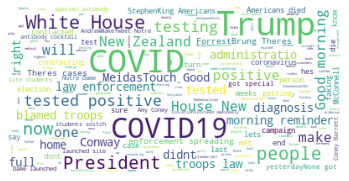

Original text preprocessed: 
 MeidasTouch Good morning This is a reminder that Trump blamed the troops and law enforcement for spreading COVID to his administratio, MeidasTouch Trump is a mass murderer Him having COVID does not erase that fact, StephenKing 850 Americans died of COVID19 yesterdayNone got the special antibody cocktail, LivePDDave1 DisgustingMSNBCs Joy Reid suggests Trump is faking COVID diagnosis to get out of the debates, Booker4KY Trump knew COVID was deadly yet he actively downplayed it called it a hoax made wearing masks a partisan issue and ignor, BreitbartNews President Trump is now presiding over one of the fastest economic recoveries in the nations history writes Bernie Ma, meenaharris Claudia Conway just posted on TikTok that Kellyanne Conway has COVID, CoriBush President Trump will not receive any medical bills for his COVID19 treatment Neither should any of us, ForrestBrung Theres more cases of Covid in the White House than in all of New Zealand, LionelMedia r

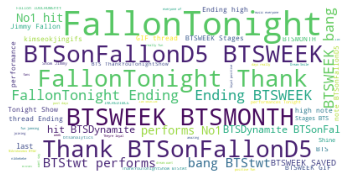

Original text preprocessed: 
 FallonTonight  Ending BTSWEEK with a bang BTStwt performs their No1 hit BTSDynamite  BTSonFal, kimseokjingifs BTSWEEK Stages  BTS  ThankYouTonightShow BTStwt, FallonTonight  Shine Dream Smile BTStwt shines in this performance of Mikrokosmos   BTSW, FallonTonight Theyre some of the most loyal positive and fun fans that you could ever dream of and I just want to say thank you to, btsanalytics BTSWEEK BTStwt performances 55 on The Tonight Show with Jimmy Fallon IDOLHOMEhtt, FallonTonight Thank you   BTSonFallonD5 BTSWEEK BTSMONTH, EXPENSIVEMENBTS This is so adorable look how Jungkook guiding Taehyung BTSWEEK BTSonFallonD5, kimseokjingifs BTSWEEK Stages  BTS  ThankYouTonightShow BTStwt, FallonTonight Theyre some of the most loyal positive and fun fans that you could ever dream of and I just want to say thank you to, FallonTonight              BTSWEEK SAVED, BTSgraphs Thank you jimmyfallon amp the team for being so welcoming amp kind to BTS BTSWEEK was amazing 

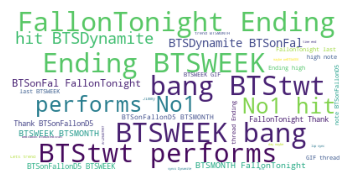

Original text preprocessed: 
 bngtaneternal FallonTonight Okay BTSMONTH, FallonTonight  Ending BTSWEEK with a bang BTStwt performs their No1 hit BTSDynamite  BTSonFal, FallonTonight  Ending BTSWEEK with a bang BTStwt performs their No1 hit BTSDynamite  BTSonFal, FallonTonight Thank you   BTSonFallonD5 BTSWEEK BTSMONTH, FallonTonight  Ending BTSWEEK with a bang BTStwt performs their No1 hit BTSDynamite  BTSonFal, Ari29407997 last day of              but maybe weBTSWEEK          get BTSMONTHBTStwt, FallonTonight Thank you   BTSonFallonD5 BTSWEEK BTSMONTH, Ari29407997 last day of              but maybe weBTSWEEK          get BTSMONTHBTStwt, FallonTonight  Ending BTSWEEK with a bang BTStwt performs their No1 hit BTSDynamite  BTSonFal, FallonTonight Our last BTSWEEK GIF thread Ending on a high note BTSonFallonD5 BTSMONTH BTSDynamite, FallonTonight  Ending BTSWEEK with a bang BTStwt performs their No1 hit BTSDynamite  BTSonFal, FallonTonight  Ending BTSWEEK with a bang BTStwt performs their 

In [382]:
for htag in htags:
  temp =  df_clean_data[htag].str.cat(sep=', ') # Select a column insert i here
  #Word Cloud
  print(f'Word Clod for the trending hashtag {htag} \n') 
  stopwords = set(STOPWORDS)
  wordcloud = WordCloud(background_color='white',stopwords=stopwords,max_words=200,max_font_size=40, random_state=42).generate(str(temp))
  fig = plt.figure(1)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()
  preprocess_text = temp.strip().replace("\n","")
  t5_prepared_Text = "summarize: "+preprocess_text
  print ("Original text preprocessed: \n", preprocess_text)
  tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt",  truncation=True)
  # summmarize 
  summary_ids = model.generate(tokenized_text,max_length=50, num_beams=5,no_repeat_ngram_size=2, 
                                num_return_sequences=5, early_stopping=True)
  output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  print(f"\n\nSummarized text for {htag}: \n",output)
  print('*' *100)
  print('\n')
print("Completed")